# **Machine Learning Programming Exercise 6: <ins>Supervised classification</ins>**


## **Objectifs**


Nous allons dans ce TP classer automatiquement des patchs extraits d'images sonar (cf. figure ci-dessous) en types de fond marin (roches, sables, vases, rides de sable verticales et à 45°, [Posidonie](https://fr.wikipedia.org/wiki/Posidonia_oceanica)).

Quelques exemples de patchs d'image sonar de fond marin:
<img src="imgs/screenshot001.png" />


L'objectif est d'écrire des scripts permettant de mettre en \oe uvre un système basé sur différentes approches supervisées de machine learning. Ces scripts devront ainsi suivre la chaîne générale décrite en cours (à l'exception de la phase de captation; cf. figure ci-dessous ) :
* prétraitements
* extraction des descripteurs
* apprentissage d'un modèle de classement
* classement des pixels
* évaluation du classifieur appris

<img src="imgs/screenshot002.png" />

Le TP est globalement organisé de la manière suivante
* **Données**
 1. tout d'abord apprendre les modèles de classement (classifieurs) sur les données brutes (descripteurs=features=valeurs des pixels) 
 2. puis dans un second temps sur des descripteurs extraits à partir d'un algorithme appelé [scattering operator](https://www.di.ens.fr/data/scattering) (le fonctionnement exact n'est pas au programme mais il s'apparente à une banque de filtres mise en cascade). 

* **Prétraitements** Aucun prétraitement ne sera réalisé. 

* **Ensembles de données**
 1. Les ensembles de données seront composés de 1/3 de la base totale d'images. 
 2. Dans un second temps, nous procéderons par [validation croisée](https://scikit-learn.org/stable/modules/cross_validation.html) car la base d'images est de taille réduite.
* **Algorithmes** 
    Concernant les algorithmes supervisés de machine learning, l'objectif est d'utiliser les deux algorithmes de regression logistique et de réseaux de neurones que vous avez développés aux TP précédents et de découvrir le package python [scikit-learn](http://scikit-learn.org/stable/user_guide.html) qui vous permettra d'utiliser les algorithmes de [régression logistique](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression), [réseaux de neurones](https://scikit-learn.org/stable/modules/neural_networks_supervised.html), [random forests](https://scikit-learn.org/stable/modules/ensemble.html#forest) et [svm](https://scikit-learn.org/stable/modules/svm.html#svm-classification).

* Pour commencer avec cette séance, vous aurez besoin de **télécharger** le _starter code_  disponible sur le lien Moodle du cours.

<span style='color:red'>**Dans cet exercice, il vous est demandé de fournir un rapport regroupant les réponses aux questions, vos analyses et vos codes. Ce rapport pourra prendre la forme d'un pdf ou d'un jupyter notebook. Il est de plus conseillé de faire tourner les codes sur google colab si votre machine manque de puissance (dans ce cas un jupyter notebook est nécessaire).**</span>


## **Fichiers inclus dans le starter code pour cette séance**
* **pythonTools.py** - fonctions utiles pour l'affichage, le chargement des données et l'évaluation des performances
* **usefulCmds.py** - quelques commandes pour faciliter l'import des patchs
* **dataSet** - répertoire avec les images et les labels correspondants
* **dataSet\imdb_200x200_SmallSonarTex_db_6classes_scatValOnly.mat** - fichier matlab contenant les descripteurs extraits des images par le scattering operator


# **Part 0: intro**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from google.colab import files
uploaded = files.upload()

Saving pythonTools.py to pythonTools.py


## **0.1 imports**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pythonTools import *
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import validation_curve, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from scipy.optimize import fmin_cg, fmin_tnc
from copy import deepcopy
import scipy.io

None


## **0.2 Examen des données**

Écrire des lignes de code permettant:
* de charger les données comprises dans le fichier _labels.csv_,
* de mettre en matrice les descripteurs de l'ensemble de la base d'images
* d'afficher les images avec la fonction _plot\_batch()_ du fichier \_pythonTools.py_,

nombre de données=  360
nombre de descripteurs=  40000


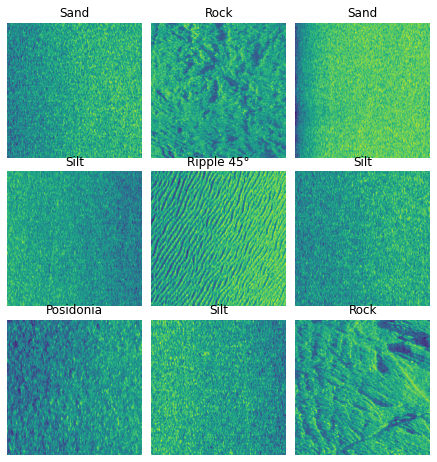

In [5]:
# Ces lignes permettent de charger les données du ficher labels.csv
DATASET_PATH = r'/content/gdrive/My Drive/projet_IA/dataset/imgs/'
LABEL_PATH = r'/content/gdrive/My Drive/projet_IA/dataset/labels/labels.csv'
dataset_df = pd.read_csv(LABEL_PATH)

dataset_df['image_path'] = dataset_df.apply( lambda row: (DATASET_PATH + row["id"] ), axis=1)
dataset_df=load_batch(dataset_df, len(dataset_df))

# Cette ligne permet de mettre en matrice les descripteurs de l'ensemble de la base d'images
feature_values = np.array([plt.imread(img).reshape(40000,) for img in dataset_df['image_path'].values.tolist()])

print("nombre de données= ", feature_values.shape[0])
print("nombre de descripteurs= ", feature_values.shape[1])

# Affichage des images
plot_batch(dataset_df, 3, 3, 200, 200)

**Question: Quel est le nombre de données, le nombres de descripteurs**

_votre réponse ici:_ le nombre de données est de **360** et le nombre de descripteurs( le nombre de pixels dans l'image) est de **200*200=40000** 

## **0.3 prétraitements des labels**

Écrire des lignes de code, un script ou une fonction _preprocessing()_ permettant:
* de disposer des labels dans différents [codages](https://scikit-learn.org/stable/modules/preprocessing_targets.html) (noms, indices, one-hot-encoding, etc.) 

In [ ]:
# Récupération des labels
label_names = dataset_df['seafloor']
label_names_unique = label_names.unique() # Extraction des labels uniques (6 targets au total)

#  transformation des labels selon différents codages
le = preprocessing.LabelEncoder()
le.fit(label_names_unique)
label_indices = le.transform(label_names)
label_indices=label_indices.reshape(label_indices.shape[0],1)# 0: Posedinia, 1: Ripple 45, 3: Rock, 4: Sand, 5: Silt, 2: Ripple vertical

# one-hot-encoding
label_ohe = pd.get_dummies(label_names.reset_index(drop=True)).values

## **0.4 Séparation des données en ensembles** 

Écrire des lignes de code, un script ou une fonction _preprocessing()_ permettant:
* de [normaliser](https://scikit-learn.org/stable/modules/preprocessing.html) les données si besoin 
* de [créer deux ensembles](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) un pour l'apprentissage et un pour le test

In [ ]:
# 70% de données d'entrainement et 30% de données de test
xtrain, xtest, ytrain, ytest = train_test_split(feature_values, label_indices, test_size=0.3)

<strong>Question: Quel est le nombre de données totales et <ins>pour chaque classe</ins>, le nombres de descripteurs pour <ins>chaque ensemble de données</ins></strong>

In [ ]:
for i in range(6):
  print("train: n_classe{} = {}".format(i,np.sum(ytrain==i)))
  print("test: n_classe{} = {}".format(i,np.sum(ytest==i)))

train: n_classe0 = 43
test: n_classe0 = 17
train: n_classe1 = 43
test: n_classe1 = 17
train: n_classe2 = 42
test: n_classe2 = 18
train: n_classe3 = 40
test: n_classe3 = 20
train: n_classe4 = 41
test: n_classe4 = 19
train: n_classe5 = 43
test: n_classe5 = 17


_votre réponse ici:_ 
* **Données totales:**
  * Classe 0(Posedinia): 60
  * Classe 1(Ripple 45): 60
  * Classe 2(Ripple vert): 60
  * Classe 3(Rock): 60
  * Classe 4(Sand): 60
  * Classe 5(Silt): 60
* **Données Entrainement:**
  * Classe 0(Posedinia): 42
  * Classe 1(Ripple 45): 43
  * Classe 2(Ripple vert): 42
  * Classe 3(Rock): 45
  * Classe 4(Sand): 36
  * Classe 5(Silt): 44
* **Données test:**
  * Classe 0(Posedinia): 18
  * Classe 1(Ripple 45): 17
  * Classe 2(Ripple vert): 18
  * Classe 3(Rock): 15
  * Classe 4(Sand): 24
  * Classe 5(Silt): 16

Le nombre de descripteurs pour chaque ensemble de données(train et test) et pour chaque classe est de 40000.


La repartition des données semble cohérent. Les classes dans le train et le test sont uniformement reparties. Cela permet de s'assurer d'un bon apprentissage et d'évaluation

# **Part 1 approches supervisées sur données brutes**

<strong><ins>Question</ins>: Y-a-t-il besoin de normaliser les descripteurs? Si oui, que faut-il conserver comme information et pourquoi?</strong> 

_votre réponse ici:_  Ici On a pas besoin de normaliser les features car les valeurs des pixels sont comprises entre 0 et 1.

**<ins>Question</ins>**: Nous allons apprendre les modèles suivants:
* régression logistique régularisée et réseaux de neurones développés dans les tps précédents,
* régression logistique, réseaux de neurones (solver=lbfgs), svm et random forest en utilisant les fonctions du package scikit-learn

**Faire la liste des hyper-paramètres (paramètre uniquement lié à l'algorithme d'apprentissage) de chaque algorithme. Comment fixe-t-on leurs valeurs?**

*votre réponse ici*: 
* **Regression Logistique:** *Lambda*(coefficient de régularisation)
* **SVM:** *Lambda* (paramètre de régularisation) et gamma (l'ecart-type du kernel gaussien)
* **Random Forest:** Le nombre d'arbre, la profondeur de chaque arbre et le nombre maximal de feuille de chaque arbre.
* **reseaux de neurones:** Le paramètre de régularisation et la learning rate

Pour fixer les hyperparametres, on peut tracer les courbes d'erreur d'entrainement et de validation en fonction de l'hyperparametre.

<strong><ins>Question</ins>: Fixez au mieux les valeurs des hyperparamètres, réalisez l'apprentissage des modèles suivants: 
* régression logistique régularisée et réseaux de neurones développés dans les tps précédents,
* régression logistique, réseaux de neurones, svm et random forest en utilisant les fonctions du package scikit-learn
</strong>

## **Entrainement des Modèles**

### **Logistic Regression from scratch**

In [ ]:
# Fonctions utiles pour la validation croisée
def removearray(L,arr):
		"""Supprimer un array d'une liste d'arrays"""
    ind = 0
    size = len(L)
    while ind != size and not np.array_equal(L[ind],arr):
        ind += 1
    if ind != size:
        L.pop(ind)
    else:
        raise ValueError('array not found in list.')

def kfold(x,y, k):
	"""
	Fonction de validation croisé:
	input: x(data), y(labels), k(nombre de plis)
	return: x_splits et y_splits
	"""
	x_splits=[]
	y_splits=[]
	n=x.shape[0]
	n_split=int(np.ceil(n/k))
	j=0
	data_copy=np.column_stack((x,y))
	np.random.shuffle(data_copy)
	for i in range(k):
		if i==k-1:
			x_splits.append(data_copy[j:,:-1])
			y_splits.append(data_copy[j:,-1])
			break
		x_splits.append(data_copy[j:j+n_split,:-1])
		y_splits.append(data_copy[j:j+n_split,-1])
		j+=n_split
	return x_splits, y_splits

In [ ]:
# Fonctions utiles pour l'apprentissage du modèle

def sigmoid(z):
  return 1/(1+np.exp(-z))

def lrCostFunction(theta, X, y, Lambda):
  """ Fonction calculant la fonction de cout"""
  m,n = X.shape
  theta = theta.reshape((n,1))
  z=X@theta
  h_x=sigmoid(z)
  J=1/m*np.sum(-y*np.log(h_x)-(1-y)*np.log(1-h_x)) + 0.5*1/m*Lambda*np.sum(theta[1:,0].T*theta[1:,0])
  return J


def lrCostGradient(theta, X, y, Lambda):
  """ Fonction calculant le gradient """
  m,n = X.shape
  theta = theta.reshape((n,1))
  z=X@theta
  h_x=sigmoid(z)
  grad=1/m*X.T@(h_x-y)
  grad[1:,0]+=1/m*Lambda*theta[1:,0]
  return grad.flatten() 

def learnOneVsAll(X, y, num_labels, Lambda):
    """ Fonction d'apprentissage"""
    m, n = X.shape
    all_theta = np.zeros((num_labels, n))
    initial_theta = np.zeros((n, 1))
    for i in range(num_labels):
        y_1vsAll = (y == i)*1

        result = fmin_tnc(lrCostFunction, fprime=lrCostGradient, x0=initial_theta, \
                              args=(X, y_1vsAll, Lambda), disp=False)
        all_theta[i,:] = result[0]

    return all_theta

def misClassError(all_theta, X, y):
  """ Fonction calculant les erreurs de classification"""
  predict=predict_OneVsAll(all_theta, X)
  predict=predict.reshape(predict.shape[0],)
  y=y.flatten()
  n_error=np.sum(((predict==y)*1)==0)
  error=n_error/X.shape[0]
  return error

def predict_OneVsAll(all_theta, X):
  """ Fonction de prediction"""
  m = X.shape[0]
  #p = np.zeros((m, 1))
  p=np.argmax(sigmoid(all_theta@X.T), axis=0)
  return p


In [ ]:
# recherche du meilleur Lambda Par validation croissé
n_Lambda=np.array([0, 0.001, 0.01, 0.1, 1, 5, 10, 30, 50, 70, 100, 1000])
errors_train=[]
errors_val=[]
k_errors_train=[]
k_errors_val=[]
n_fold=5
for Lambda in n_Lambda:
  X, y=kfold(xtrain, ytrain, n_fold)
  print("For Lambda", Lambda)
  print("----------------------------------------")
  for i in range(n_fold):
    xval = X[i]
    yval=y[i]
    Lx=deepcopy(X)
    removearray(Lx, X[i])
    Ly=deepcopy(y)
    removearray(Ly, y[i])
    x_train, y_train=Lx[0], Ly[0].reshape(Ly[0].shape[0],1)
    for j in range(1,len(Lx)):
      x_train, y_train=np.vstack((Lx[j], x_train)), np.vstack((Ly[j].reshape(Ly[j].shape[0],1), y_train))
    x_train = np.column_stack((np.ones((x_train.shape[0], 1)), x_train))
    xval = np.column_stack((np.ones((xval.shape[0], 1)), xval))
    theta=learnOneVsAll(x_train, y_train, 6, Lambda)
    k_errors_train.append(misClassError(theta, x_train, y_train))
    k_errors_val.append(misClassError(theta, xval, yval))
  errors_train.append(np.array(k_errors_train).mean())
  errors_val.append(np.array(k_errors_val).mean())
  print("error_train=", errors_train[-1])
  print("error_val=", errors_val[-1])
  k_errors_train.clear()
  k_errors_val.clear()
  

For Lambda 0.0
----------------------------------------
error_train= 0.0
error_val= 0.6259803921568627
For Lambda 0.001
----------------------------------------
error_train= 0.0
error_val= 0.5987745098039216
For Lambda 0.01
----------------------------------------
error_train= 0.0
error_val= 0.5960784313725489
For Lambda 0.1
----------------------------------------
error_train= 0.0
error_val= 0.571078431372549
For Lambda 1.0
----------------------------------------
error_train= 0.0009950248756218905
error_val= 0.5909313725490197
For Lambda 5.0
----------------------------------------
error_train= 0.04960491659350307
error_val= 0.5745098039215686
For Lambda 10.0
----------------------------------------
error_train= 0.10608721100380451
error_val= 0.5840686274509804
For Lambda 30.0
----------------------------------------
error_train= 0.24398595258999123
error_val= 0.6357843137254903
For Lambda 50.0
----------------------------------------
error_train= 0.3382352941176471
error_val= 0.6230

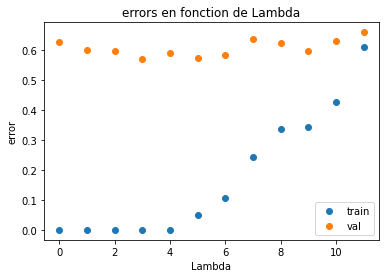

In [ ]:
# Affichage des erreurs de classifications en fonction de Lambda
plt.figure()
plt.xlabel("Lambda")
plt.ylabel("error")
plt.scatter(range(12), errors_train)
plt.scatter(range(12), errors_val)
plt.title("errors en fonction de Lambda")
plt.legend(("train", "val"))
plt.show()

In [ ]:
# Entrainement du modèle
# Meilleur Lambda trouver est de 0.1
Lambda=0.1
X = np.column_stack((np.ones((xtrain.shape[0], 1)), xtrain))
all_theta = learnOneVsAll(X, ytrain, 6, Lambda)

In [ ]:
# prediction sur les données de test
Xtest = np.column_stack((np.ones((xtest.shape[0], 1)), xtest))
predictions_Log_tps=predict_OneVsAll(all_theta, Xtest)

### **Reseaux de neurones from scratch**

In [ ]:
# Fonctions utiles pour l'apprentissage du reseau
def sigmoidGradient(z):
	g=sigmoid(z)*(1-sigmoid(z))
	return g

def randInitializeWeights(L_in, L_out):
    """ Fonction initialisant les paramètres"""
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1+L_in) * 2 * epsilon_init - epsilon_init
    return W

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, Lambda):
    """" Fonction calculant la cost function et le gradiant"""
    theta1 = nn_params[0:(hidden_layer_size*(input_layer_size+1))].reshape((input_layer_size+1),hidden_layer_size).T
    theta2 = nn_params[(hidden_layer_size*(input_layer_size+1)):].reshape((hidden_layer_size+1),num_labels).T
    m, _ = X.shape
    J = 0
    theta1_grad = np.zeros(theta1.shape);
    theta2_grad = np.zeros(theta2.shape);

    y_matrix = np.zeros((num_labels,m))
    for i in range(m):
      y_matrix[y[i,0],i]=1
    
    # Compute Cost
    a1=np.column_stack((np.ones((X.shape[0], 1)), X)) #ajout du bias unit
    z2=a1@theta1.T
    a2=sigmoid(z2)
    a2 = np.column_stack((np.ones((a2.shape[0], 1)), a2)) #ajout du bias unit
    z3=a2@theta2.T
    a3=sigmoid(z3)
    h_x=a3
    J=np.sum(-np.log(h_x)*y_matrix.T-np.log(1-h_x)*(1-y_matrix).T)
    
    # Cost regularisation
    reg = (Lambda/(2*m))*(np.sum(np.square(theta1[:,1:])) + np.sum(np.square(theta2[:,1:])))
    J = J/m + reg

    # Gradients
    d3 = a3 - y_matrix.T
    d2 = theta2[:,1:].T.dot(d3.T)*sigmoidGradient(z2.T)
    
    delta1 = d2.dot(a1)
    delta2 = d3.T.dot(a2)
    
    # Gradient regularisation
    theta1_grad = delta1/m  
    reg = (theta1[:,1:]*Lambda)/m
    theta1_grad[:,1:] = theta1_grad[:,1:] + reg
    
    theta2_grad = delta2/m  
    reg = (theta2[:,1:]*Lambda)/m
    theta2_grad[:,1:] = theta2_grad[:,1:] + reg
    grad = np.hstack((theta1_grad.T.ravel(), theta2_grad.T.ravel()))
    return J, grad

def predictNeuralNetwork(Theta1, Theta2, X):
    """" Fonction de prediction
    input: Theta1, Theta2(les poids du reseau) et X(données à prédire)
    output: p(les labesl) 
    """
    m, _ = X.shape
    num_labels, _ = Theta2.shape
    a1=np.column_stack((np.ones((X.shape[0], 1)), X))
    z2=Theta1@a1.T
    a2=sigmoid(z2).T
    a2 = np.column_stack((np.ones((a2.shape[0], 1)), a2))
    z3=Theta2@a2.T
    a3=sigmoid(z3)
    p=np.argmax(a3, axis=0)
    return p

def misClassError2(Theta1, Theta2, X, y):
  """ Fonction calculant les erreurs de classification"""
  predict=predictNeuralNetwork(Theta1, Theta2, X)
  predict=predict.reshape(predict.shape[0],)
  y=y.flatten()
  n_error=np.sum(((predict==y)*1)==0)
  error=n_error/X.shape[0]
  return error

In [ ]:
# Initialisation des poids des neurones
input_layer_size  = 40000  # 200x200 Input Images of sea floor
hidden_layer_size = 100   # 25 hidden units
num_labels = 6          # 6 labels, from 1 to 10   


initial_theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
initial_theta2 = randInitializeWeights(hidden_layer_size, num_labels)

# Unroll parameters
initial_nn_params = np.hstack((initial_theta1.T.ravel(), initial_theta2.T.ravel()))

In [ ]:
# Recherche de la learning rate
# Après tatonnemnt, on obtient une learning rate à 5e-11
errors=[]
examples=[]
for inter in np.linspace(1,800, 20):
  costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, xtrain, ytrain, 0)[0]
  gradFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, xtrain, ytrain, 0)[1]
  result = fmin_cg(costFunc, fprime=gradFunc, x0=initial_nn_params, epsilon=5e-11, maxiter=inter, disp=True,full_output=True)
  cost = result[1]
  print("cost=", cost)
  examples.append(inter)
  errors.append(cost)

[3.1118273978498765, 2.4775146809366615, 2.1473041223156364, 1.7678058869004767, 1.5640597280054211, 1.1221465630262872, 0.8901011665103712, 0.3316740890464712, 0.1579530600223611, 0.11546007813365156, 0.09982439334736493, 0.07809294698631788, 0.07027035398122615, 0.048123843120580746, 0.03645843091086375, 0.030750391009745557, 0.028438780799439723, 0.02295050711881098, 0.02104303284075206, 0.0010568918551011233]


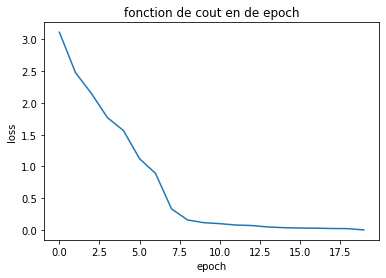

In [ ]:
#errors=[3.1118273978498765, 2.4775146809366615, 2.1473041223156364, 1.7678058869004767, 1.5640597280054211, 1.1221465630262872, 0.8901011665103712, 0.3316740890464712, 0.1579530600223611, 0.11546007813365156, 0.09982439334736493, 0.07809294698631788, 0.07027035398122615, 0.048123843120580746, 0.03645843091086375, 0.030750391009745557, 0.028438780799439723, 0.02295050711881098, 0.02104303284075206, 0.0010568918551011233]
# Courbe d'erreurs en fonction du nombre d'iterations 
print(errors)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(errors)
plt.title("fonction de cout en de epoch")
plt.show()

In [ ]:
# Recherche du meilleur Lambda Par validation Crossé
n_Lambda=np.logspace(-4,2,7)
errors_train=[]
errors_val=[]
k_errors_train=[]
k_errors_val=[]
n_fold=5
for Lambda in n_Lambda:
  X, y=kfold(xtrain, ytrain, n_fold)
  print("For Lambda", Lambda)
  print("----------------------")
  for i in range(n_fold):
    xval = X[i]
    yval=y[i]
    Lx=deepcopy(X)
    removearray(Lx, X[i])
    Ly=deepcopy(y)
    removearray(Ly, y[i])
    x_train, y_train=Lx[0], Ly[0].reshape(Ly[0].shape[0],1)
    for j in range(1,len(Lx)):
      x_train, y_train=np.vstack((Lx[j], x_train)), np.vstack((Ly[j].reshape(Ly[j].shape[0],1), y_train))
    costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, x_train, y_train.astype(int), Lambda)[0]
    gradFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, x_train, y_train.astype(int), Lambda)[1]
    result = fmin_cg(costFunc, fprime=gradFunc, x0=initial_nn_params, epsilon=5e-11, maxiter=800, disp=True,full_output=True)
    nn_params = result[0]
    theta1 = nn_params[0:(hidden_layer_size*(input_layer_size+1))].reshape((input_layer_size+1),hidden_layer_size).T
    theta2 = nn_params[(hidden_layer_size*(input_layer_size+1)):].reshape((hidden_layer_size+1),num_labels).T
    cost_train=misClassError2(theta1, theta2, x_train, y_train)
    cost_val=misClassError2(theta1, theta2, xval, yval)
    k_errors_train.append(cost_train)
    k_errors_val.append(cost_val)
  errors_train.append(np.array(k_errors_train).mean())
  errors_val.append(np.array(k_errors_val).mean())
  print("cost_train=", errors_train[-1])
  print("cost_val=", errors_val[-1])
  k_errors_train.clear()
  k_errors_val.clear()

print(errors_train)
print(errors_val)

meilleur Lambda est: 1.0


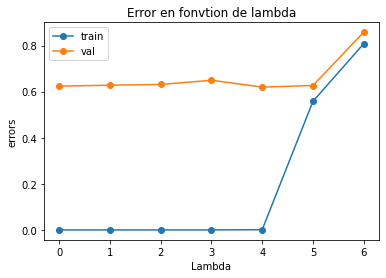

In [ ]:
# Courbe d'erreurs de classification et de validation en fonction de Lambda
n_Lambda=np.logspace(-4,2,7)
errors_train=[0.0, 0.0, 0.0, 0.0, 0.0009950248756218905, 0.5576382791922738, 0.8075065847234416]
errors_val=[0.62377451, 0.627941176, 0.6311274499999999, 0.649264704, 0.619607842, 0.626470588, 0.8575980380000001]
print("meilleur Lambda est:", n_Lambda[np.argmin(errors_val)])
plt.figure()
plt.xlabel("Lambda")
plt.ylabel("errors")
plt.plot(errors_train,'-o')
plt.plot(errors_val, '-o')
plt.title("Error en fonvtion de lambda")
plt.legend(('train', 'val'))

In [ ]:
# Entrainement du modèle avec le meilleur hyperparamètre Lambda

Lambda = 1.0
costFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, xtrain, ytrain, Lambda)[0]
gradFunc = lambda p: nnCostFunction(p, input_layer_size, hidden_layer_size, num_labels, xtrain, ytrain, Lambda)[1]

result = fmin_cg(costFunc, fprime=gradFunc, x0=initial_nn_params, epsilon=5e-11, maxiter=800, disp=True,full_output=True)
nn_params = result[0]
cost = result[1]
print("cost=", cost)
theta1 = nn_params[0:(hidden_layer_size*(input_layer_size+1))].reshape((input_layer_size+1),hidden_layer_size).T
theta2 = nn_params[(hidden_layer_size*(input_layer_size+1)):].reshape((hidden_layer_size+1),num_labels).T

         Current function value: 1.253794
         Iterations: 800
         Function evaluations: 1414
         Gradient evaluations: 1414
cost= 1.2537942365191643


In [ ]:
# prediction sur les données de test
predictions_nn_tps = predictNeuralNetwork(theta1, theta2, xtest)

### **Logistic Regression**

In [ ]:
# Recherche manuelle de l'hyperparamtre Lambda (C) apr validation croisé
n_Lambda = np.logspace(-3,3, 7)
score_train, score_val= validation_curve(LogisticRegression(), xtrain, ytrain, 'C', n_Lambda, cv=5)
errors_train = 1-score_train.mean(axis=1)
errors_val = 1-score_val.mean(axis=1)

meiileur Lambda est:  0.1


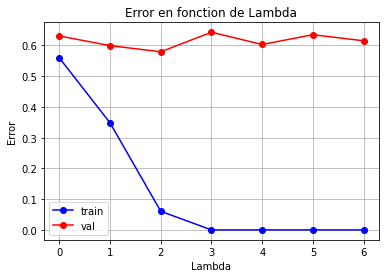

In [ ]:
# Affichage de la courbe d'erreur en fonction de Lambda
print("meiileur Lambda est: ", n_Lambda[np.argmin(errors_val)])
plt.figure()
plt.grid()
plt.ylabel("Error")
plt.xlabel("Lambda")
plt.plot(errors_train, 'o-', color='blue')
plt.plot(errors_val, 'o-', color='red')
plt.title("Error en fonction de Lambda")
plt.legend(("train", "val"))
plt.show()

In [ ]:
# On utilise le parametre Lambda pour entrainer le modèle et faire des predictions sur les données de test
classifier_LogR=LogisticRegression(C=n_Lambda[np.argmin(errors_val)])
predictions_LogR=train_predict_model(classifier_LogR, xtrain, ytrain, xtest, ytest)

In [ ]:
# Calcul des scores pour pour le train set et le cross-validation set
train_size, train_error, cross_error=learning_curve(classifier_LogR, xtrain, ytrain,cv=5, n_jobs=-1)

error in the cross_validation test= [0.75380392 0.61121569 0.63098039 0.61890196 0.58321569]
error in the train set test= [0.04       0.07384615 0.08909091 0.06064516 0.07462687]


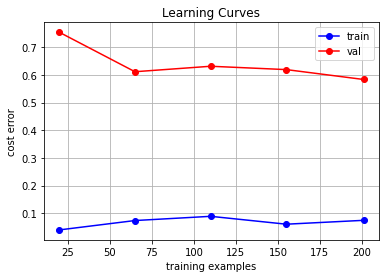

In [ ]:
# Affichage de la learning curve
train_error_mean = 1-np.mean(train_error, axis=1)
cross_error_mean = 1-np.mean(cross_error, axis=1)
print("error in the cross_validation test=", cross_error_mean)
print("error in the train set test=", train_error_mean)
plt.figure()
plt.grid()
plt.ylabel("cost error")
plt.xlabel("training examples")
plt.plot(train_size, train_error_mean, 'o-', color='blue')
plt.plot(train_size, cross_error_mean, 'o-', color='red')
plt.title("Learning Curves")
plt.legend(("train", "val"))
plt.show()

### **Reseaux de neurones**

In [ ]:
# Recherche de la Learning rate
# Après tatonnement, on obtient 1e-5
errors=[]
for i in np.linspace(1,300, 10):
  neur_net=MLPClassifier(hidden_layer_sizes=(100,), max_iter=i,activation = 'relu', learning_rate_init=1e-5, solver='lbfgs',random_state=1)
  neur_net.fit(xtrain, ytrain)
  loss=neur_net.loss_
  print(loss)
  errors.append(loss)

1.7929010329401163
0.660907673343612
0.1859237530138821
0.11939355325921981
0.004833499768691156
0.004168684296795063
0.004066006691437253
0.003919175122295969
0.00319508092523708
0.0026613048354874468


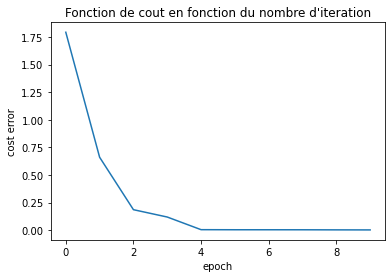

In [ ]:
# Courbe d'erreurs en fonction du nombre d'itérations
plt.figure()
plt.xlabel("epoch")
plt.ylabel("cost error")
plt.title("Fonction de cout en fonction du nombre d'iteration")
plt.plot(errors)
plt.show()

In [ ]:
# Recherche manuelle de l'hyperparamtre Lambda (alpha) apr validation croisé
alphas = np.logspace(-3,3, 7)
classifier_nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation = 'relu', learning_rate_init=1e-5, solver='lbfgs',random_state=1)
score_train, score_val= validation_curve(classifier_nn, xtrain, ytrain, 'alpha', alphas, cv=5)
errors_train = 1-score_train.mean(axis=1)
errors_val = 1-score_val.mean(axis=1)

meilleur paramètre: 1.0


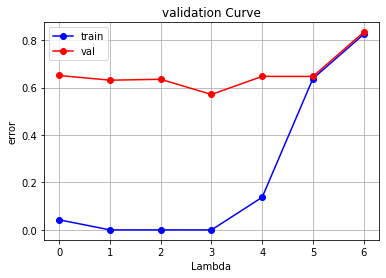

In [ ]:
# Affichage de la validation curve
print("meilleur paramètre:", alphas[np.argmin(errors_val)])
plt.figure()
plt.grid()
plt.ylabel("error")
plt.xlabel("Lambda")
plt.plot(errors_train, 'o-', color='blue')
plt.plot(errors_val, 'o-', color='red')
plt.title("validation Curve")
plt.legend(("train", "val"))
plt.show()

In [ ]:
# Entrainement du modèle avec les meilleurs hyperparamètres
classifier_nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation = 'relu', alpha=alphas[np.argmin(errors_val)], learning_rate_init=1e-5, solver='lbfgs',random_state=1)
predictions_nn = train_predict_model(classifier_nn, xtrain, ytrain, xtest, ytest)

In [ ]:
# Entrainement du modèle avec les meilleurs hyperparamètres
classifier_nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation = 'relu', alpha=0.01, learning_rate_init=1e-5, solver='lbfgs',random_state=1)
predictions_nn = train_predict_model(classifier_nn, xtrain, ytrain, xtest, ytest)

In [ ]:
# Calcul des scores pour le train set et le cross-validation set pour le reseaux de neurones
train_size, train_error, cross_error=learning_curve(classifier_nn, xtrain, ytrain, n_jobs=-1)

error in the cross_validation test= [0.77396078 0.74227451 0.68290196 0.69796078 0.66290196]
error in the train set test= [0.         0.         0.         0.04774194 0.        ]


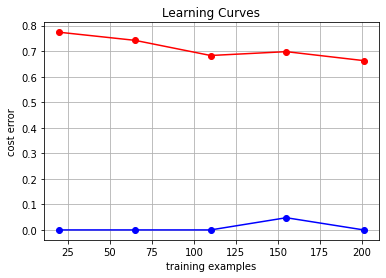

In [ ]:
# Affichage de la learning curve pour le reseau de neurone
train_error_mean = 1-np.mean(train_error, axis=1)
cross_error_mean = 1-np.mean(cross_error, axis=1)
print("error in the cross_validation test=", cross_error_mean)
print("error in the train set test=", train_error_mean)
plt.figure()
plt.grid()
plt.ylabel("cost error")
plt.xlabel("training examples")
plt.plot(train_size, train_error_mean, 'o-', color='blue', label="train cost error")
plt.plot(train_size, cross_error_mean, 'o-', color='red', label="cross_val cost error")
plt.title("Learning Curves")
plt.show()

### **Support Vector Machine (SVM)**

In [ ]:
# Recherche manuelle de l'hyperparamtre gamma
n_gamma = np.logspace(-3,1, 20)
score_train, score_val= validation_curve(svm.SVC(kernel="rbf"), xtrain, ytrain, 'gamma', n_gamma, cv=5)
errors_train = 1-score_train.mean(axis=1)
errors_val = 1-score_val.mean(axis=1)

meiileur gamma est:  0.04832930238571752


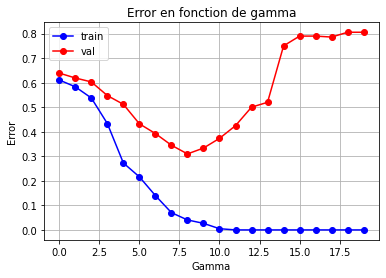

In [ ]:
# Affichage de la courbe de validation
print("meiileur gamma est: ", n_gamma[np.argmin(errors_val)])
plt.figure()
plt.grid()
plt.ylabel("Error")
plt.xlabel("Gamma")
plt.plot(errors_train, 'o-', color='blue')
plt.plot(errors_val, 'o-', color='red')
plt.title("Error en fonction de gamma")
plt.legend(("train", "val"))
plt.show()

In [ ]:
# Recherche manuelle de l'hyperparamtre Lambda
n_Lambda = np.logspace(-2, 3, 20)
score_train, score_val= validation_curve(svm.SVC(kernel="rbf", gamma = n_gamma[np.argmin(errors_val)]), xtrain, ytrain, 'C', n_Lambda, cv=5)
errors_train2 = 1-score_train.mean(axis=1)
errors_val2 = 1-score_val.mean(axis=1)

meiileur Lambda est:  2.3357214690901213


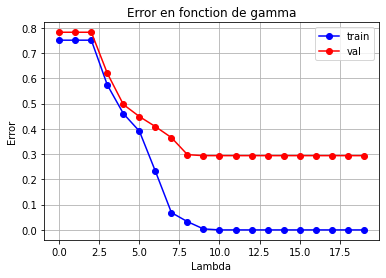

In [ ]:
# validation curve
print("meiileur Lambda est: ", n_Lambda[np.argmin(errors_val2)])
plt.figure()
plt.grid()
plt.ylabel("Error")
plt.xlabel("Lambda")
plt.plot(errors_train2, 'o-', color='blue')
plt.plot(errors_val2, 'o-', color='red')
plt.title("Error en fonction de gamma")
plt.legend(("train", "val"))
plt.show()

In [ ]:
# Entrainement du bon modèle
classifier_svm = svm.SVC(C=n_Lambda[np.argmin(errors_val2)], kernel="rbf", gamma= n_gamma[np.argmin(errors_val)])
predictions_svm = train_predict_model(classifier_svm, xtrain, ytrain, xtest, ytest)

In [ ]:
# calcul des scores pour la learning curve
train_size, train_error, cross_error=learning_curve(classifier_svm, xtrain, ytrain)

error in the cross_validation test= [0.61105882 0.40462745 0.30956863 0.29356863 0.29388235]
error in the train set test= [0.         0.00307692 0.         0.         0.0039801 ]


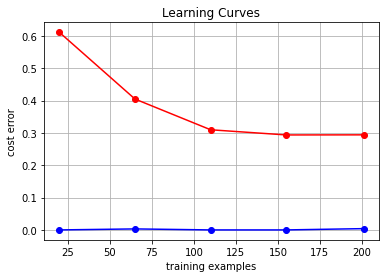

In [ ]:
# Affichage de la learning curve pour la SVM
train_error_mean = 1-np.mean(train_error, axis=1)
cross_error_mean = 1-np.mean(cross_error, axis=1)
print("error in the cross_validation test=", cross_error_mean)
print("error in the train set test=", train_error_mean)
plt.figure()
plt.grid()
plt.ylabel("cost error")
plt.xlabel("training examples")
plt.plot(train_size, train_error_mean, '-o', color='blue', label="train cost error")
plt.plot(train_size, cross_error_mean, '-o', color='red', label="cross_val cost error")
plt.title("Learning Curves")
plt.show()

### **Random Forest**

meiileur n_trees est:  700


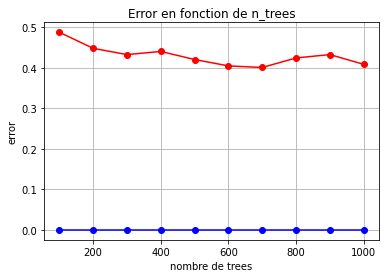

In [ ]:
# On recherche le nombre d'arbre optimale
n_trees = [i*100 for i in range(1,11)]
score_train, score_val= validation_curve(RandomForestClassifier(), xtrain, ytrain, 'n_estimators', n_trees, cv=5)
errors_train = 1-score_train.mean(axis=1)
errors_val_tree = 1-score_val.mean(axis=1)
print("meiileur n_trees est: ", n_trees[np.argmin(errors_val_tree)])
plt.figure()
plt.grid()
plt.ylabel("error")
plt.xlabel("nombre de trees")
plt.plot(n_trees, errors_train, '-o', color='blue', label="error")
plt.plot(n_trees, errors_val_tree, '-o', color='red', label="error")
plt.title("Error en fonction de n_trees")
plt.show()



meiileur profondeur est:  10


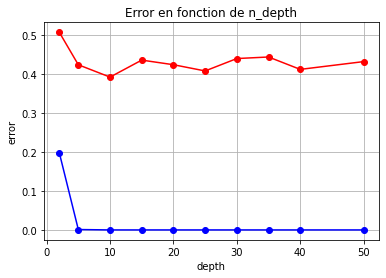

In [ ]:
# On recherche la meilleur profondeur
n_depth = [2, 5, 10, 15, 20, 25, 30, 35, 40, 50]
score_train, score_val= validation_curve(RandomForestClassifier(n_estimators=n_trees[np.argmin(errors_val_tree)]), xtrain, ytrain, 'max_depth', n_depth, cv=5)
errors_train = 1-score_train.mean(axis=1)
errors_val_depth = 1-score_val.mean(axis=1)
print("meiileur profondeur est: ", n_depth[np.argmin(errors_val_depth)])
plt.figure()
plt.grid()
plt.ylabel("error")
plt.xlabel("depth")
plt.plot(n_depth, errors_train, 'o-', color='blue', label="error")
plt.plot(n_depth, errors_val_depth, 'o-', color='red', label="error")
plt.title("Error en fonction de n_depth")
plt.show()

meiileur max_leafs est:  35


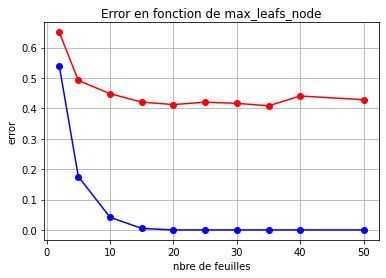

In [ ]:
# On cherche le meilleur max_leafs_nodes
n_leafs = [2, 5, 10, 15, 20, 25, 30, 35, 40, 50]
score_train, score_val= validation_curve(RandomForestClassifier(n_estimators=n_trees[np.argmin(errors_val_tree)], max_depth=n_depth[np.argmin(errors_val_depth)]), xtrain, ytrain, 'max_leaf_nodes', n_leafs, cv=5)
errors_train = 1-score_train.mean(axis=1)
errors_val_leafs = 1-score_val.mean(axis=1)
print("meiileur max_leafs est: ", n_leafs[np.argmin(errors_val_leafs)])
plt.figure()
plt.grid()
plt.ylabel("error")
plt.xlabel("nbre de feuilles")
plt.plot(n_leafs, errors_train, 'o-', color='blue', label="train error")
plt.plot(n_leafs, errors_val_leafs, 'o-', color='red', label="val error")
plt.title("Error en fonction de max_leafs_node")
plt.show()

In [ ]:
# Entrainer du modele avec les bons hyperparamteres
classifier_rfc = RandomForestClassifier(n_estimators=n_trees[np.argmin(errors_val_tree)], max_depth=n_depth[np.argmin(errors_val_depth)], max_leaf_nodes=n_leafs[np.argmin(errors_val_leafs)])
predictions_rfc=train_predict_model(classifier_rfc, xtrain, ytrain, xtest, ytest)

In [ ]:
# calcul des scores pour la learning curve
train_size, train_error, cross_error=learning_curve(classifier_rfc, xtrain, ytrain)

error in the cross_validation test= [0.66243137 0.50776471 0.50015686 0.46815686 0.42047059]
error in the train set test= [0. 0. 0. 0. 0.]


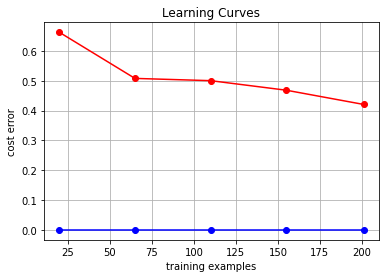

In [ ]:
# Affichage de la learning curve pour la SVM
train_error_mean = 1-np.mean(train_error, axis=1)
cross_error_mean = 1-np.mean(cross_error, axis=1)
print("error in the cross_validation test=", cross_error_mean)
print("error in the train set test=", train_error_mean)
plt.figure()
plt.grid()
plt.ylabel("cost error")
plt.xlabel("training examples")
plt.plot(train_size, train_error_mean, '-o', color='blue', label="train cost error")
plt.plot(train_size, cross_error_mean, '-o', color='red', label="cross_val cost error")
plt.title("Learning Curves")
plt.show()

## **<ins>Question</ins>: Évaluer les modèles appris en décrivant votre méthode**

### **Logique regression (tps)**

In [ ]:
display_model_performance_metrics(ytest, predictions_Log_tps, np.array([0,1,2,3,4,5]))

Model Performance metrics:
------------------------------
Accuracy: 0.4074
Precision: 0.3485
Recall: 0.4074
F1 Score: 0.3104

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.36      0.19      0.24        27
           1       0.00      0.00      0.00        17
           2       1.00      0.20      0.33        10
           3       0.00      0.00      0.00        14
           4       0.57      0.85      0.68        20
           5       0.33      1.00      0.50        20

    accuracy                           0.41       108
   macro avg       0.38      0.37      0.29       108
weighted avg       0.35      0.41      0.31       108


Prediction Confusion Matrix:
------------------------------
          Predicted:                 
                   0  1  2  3   4   5
Actual: 0          5  0  0  0   4  18
        1          6  0  0  0   6   5
        2          0  0  2  0   3   5
        3          0

Le premier algorithme d'apprentissage étudié ici est la regression logistique (tps). Il a été codée from scratch. L'hyperparametre que cherchons à fixer est le parametre de régularisation Lambda. Pour pour trouver cet hyperparametre, nous avons tracer la 'validation curve' de l'error de classification en fonction de Lambda. Le meilleur hyparametre trouver est pour Lambda=0.1.

Les performances du modèle ne sont pas bonnes de manière globale:on obtient une accuracy globale de 41% et une précision de 35%. On observe des résultats plutots étranges. On a une précision de 100% pour la classe 2 avec une accuracy de 20%. On note ce résultat inverse pour la classe 5: 100% d'accuracy et 33% de précision. Les classe 1 et 3 quand eux n'ont jamais été apprise. 

Ces résultats sont à la dimension élévé de l'espace des descripteurs (40000) et au choix du modèle qui est linéaire. Puisqu'il n'ya pas eu d'étape d'extraction des features, on ne s'attend pas non plus à un bon résultat

Conclusion: Ce modèle ne peut pas du tout être utilisé pour classifier ces images.

### **Reseau de neurone (tps)**

In [ ]:
display_model_performance_metrics(ytest, predictions_nn_tps, np.array([0,1,2,3,4,5]))

Model Performance metrics:
------------------------------
Accuracy: 0.4537
Precision: 0.5763
Recall: 0.4537
F1 Score: 0.3669

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.40      0.30      0.34        27
           1       0.50      0.06      0.11        17
           2       1.00      0.10      0.18        10
           3       1.00      0.07      0.13        14
           4       0.56      0.90      0.69        20
           5       0.38      1.00      0.56        20

    accuracy                           0.45       108
   macro avg       0.64      0.40      0.33       108
weighted avg       0.58      0.45      0.37       108


Prediction Confusion Matrix:
------------------------------
          Predicted:                 
                   0  1  2  3   4   5
Actual: 0          8  0  0  0   4  15
        1          7  1  0  0   5   4
        2          2  0  1  0   4   3
        3          1

Le deuxième algorithme d'apprentissage étudié dans ce projet projet est le réseau de neurone (tps). Il a été codé from scratch. Pour ce modèle nous avons chercher à fixer 2 hyperparamètres: la learning rate et le coefficient de regularisation Lambda. Pour déterminer la meilleur learning rate, nous avons tracé le coût en fonction du nombre d'itération. En faisant varier la learning rate et en fixant le nombre d'itération à 800, on obtient 5e-11 comme valeur. Pour le paramètre Lambda, nous avons utiliser les mêmes méthodes comme précédemment c'est-à-dire la cross-validation et la learning curve.

Après apprentissage du modèle, nous avons obtenu des résultats meilleurs que précédemment. On a une accuracy de 45% et une précision de 58%. On note que les classes 1 et 2 ont une précision de 100% mais avec des accuracy très faible.

Malgré qu'un réseau de neurone permet d'avoir des frontières de décision non-linéaire, on obtient des résultats pas utilisables. Cela au problème de la dimensionnalité et à l'absence de l'étape d'extraction des features. 

### **Logistic regression**


In [ ]:
display_model_performance_metrics(ytest, predictions_LogR, np.array([0,1,2,3,4,5]))

Model Performance metrics:
------------------------------
Accuracy: 0.4259
Precision: 0.4982
Recall: 0.4259
F1 Score: 0.3597

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        19
           1       0.19      0.45      0.26        11
           2       1.00      0.08      0.15        24
           3       0.47      0.53      0.50        17
           4       0.57      0.94      0.71        17
           5       0.50      0.70      0.58        20

    accuracy                           0.43       108
   macro avg       0.46      0.45      0.37       108
weighted avg       0.50      0.43      0.36       108


Prediction Confusion Matrix:
------------------------------
          Predicted:                 
                   0  1  2  3   4   5
Actual: 0          0  8  0  4   2   5
        1          0  5  0  0   5   1
        2          3  9  2  4   5   1
        3          0

Le modèle appris ici est celui de la regression logistic de scikit-learn. On s'apercoit que ce modèle à un recall global et une précision globale de respectivement 43% et 50%. Des résultats pas satisfaisant. Cela peut s'expliquer par le fait que le modèle utilisé est linéaire. Donc en choissant un modèle de prédiction linéaire, on considère que les données sont linéairement séparables. Cela n'est peut-etre pas le cas. Donc même avec un meilleur hyperparamètre Lambda, on obtient un résultat pas utilisable. La solution serait de faire une regression polynomiale, donc de créer de nouvelles features. Mais On s'apercoit très rapidement que pour une regression polynomiale d'ordre 2, le nombre de features devient environ 40000*40000=10e9 features, Ce qui est énorme. Face à ce probleme de dimension élevé, on ne peut que consideré des frontières de décisions linéaires. On note quand même un bon recall pour les classes 4 et 5 (94 et 70%). La classe0 n'a pas été apprise.
Le tracé de la learning curve montre une variance importante du modèle (une dépendance forte au training set). Cela peut s'expliquer par le nombre important de descripteurs (40000) ou et à l'absence de l'étape d'extraction des descripteurs.

### **Reseau de neurone**

In [ ]:
display_model_performance_metrics(ytest, predictions_nn, np.array([0,1,2,3,4,5]))

Model Performance metrics:
------------------------------
Accuracy: 0.3333
Precision: 0.5681
Recall: 0.3333
F1 Score: 0.2987

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.27      0.69      0.39        16
           1       0.50      0.06      0.11        17
           2       1.00      0.11      0.19        19
           3       1.00      0.19      0.32        16
           4       0.43      0.50      0.47        20
           5       0.24      0.45      0.32        20

    accuracy                           0.33       108
   macro avg       0.57      0.33      0.30       108
weighted avg       0.57      0.33      0.30       108


Prediction Confusion Matrix:
------------------------------
          Predicted:                
                   0  1  2  3   4  5
Actual: 0         11  0  0  0   0  5
        1          7  1  0  0   4  5
        2         11  0  2  0   1  5
        3          0  1  

Le modèle appris ici le reseau de neurone de scikit-learn. Nous avons fait le choix de travailler avec une seule hidden layer (car plus il y'a d'hidden layers plus le modèle est lent à entrainer) et les hyperparamètres à fixer sont: la learning rate et le paramètre de régularisation Lambda. Comme dans les cas précédants, le tracé de la validation curve permet de trouver le paramètre de régularisation et celui du coût en fonction du nombre d'itérations permet de trouver la learning rate.

Après avoir trouver les meilleurs hyperparamètres puis entrainer le modèle, nous avons tracé la learning curve. On apercoit encore le problème de la variance élévé. Quand aux résultats une précision de 56% et une accuracy de 33%.

Des résultats similaires aux autres modèles étudiés précédemment. La raision est la même que celles cités précédemment.

### **Support Vector Machine (SVM)**

In [ ]:
display_model_performance_metrics(ytest, predictions_svm, np.array([0,1,2,3,4,5]))

Model Performance metrics:
------------------------------
Accuracy: 0.6667
Precision: 0.675
Recall: 0.6667
F1 Score: 0.6312

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.67      0.76      0.71        21
           1       0.71      0.21      0.32        24
           2       0.46      0.40      0.43        15
           3       0.52      0.86      0.65        14
           4       0.74      0.94      0.83        18
           5       0.89      1.00      0.94        16

    accuracy                           0.67       108
   macro avg       0.67      0.70      0.65       108
weighted avg       0.67      0.67      0.63       108


Prediction Confusion Matrix:
------------------------------
          Predicted:                  
                   0  1  2   3   4   5
Actual: 0         16  0  0   0   3   2
        1          6  5  6   5   2   0
        2          1  1  6   6   1   0
        3       

Le modèle appris ici est la SVM (support vector machines). Deux hyperparametres sont à rechercher:e paramètre de régularisation Lambda et l'écart-type gamma. Nous avons fait le choix de fixer le kernel (gaussien). En tracant les courbes de validation curve pour les deux paramètres Gamma et Lambda par validation croisé.
Après avoir touver les meilleurs parametres puis entrainer le modèle, on est passer à l'évaluation du modèle.
On voit que le modèle de la SVM à une précision globale de 67% et une accuracy de 67%. Mais en analysant pour chaque classe les différentes métriques, On voit que le modèle n'est pas performant quand à la detection de **tous** les "ripple 45°" (recall= 21% classe1). Mais la précision du modèle à identifier cette classe est de 40%. Ce qui signifie que parmi toutes les predictions que fait le modèle de la SVM pour la classe 1, seulement 70% sont correctes.
Par contre on voit le modèle est très efficace Quand à l'identification de la classe5 (silt). Il a une recall de 100% et une précision de 89%. Ce qui signifie que le modèle identifie tous les silts et se trompe que rarement. Ce qui est Quand même un bon résultat.

La SVM à un meilleur résultat que tous les modèles étudié précédemment. Mais elle reste quand même limité quand à son utilisation

### **Random Froest**

In [ ]:
display_model_performance_metrics(ytest, predictions_rfc, np.array([0,1,2,3,4,5]))
#plot_model_roc_curve(classifier_rfc, xtrain, true_labels, label_encoder=None, class_names=None)

Model Performance metrics:
------------------------------
Accuracy: 0.6389
Precision: 0.6314
Recall: 0.6389
F1 Score: 0.6202

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.37      0.33      0.35        21
           1       0.44      0.29      0.35        14
           2       0.86      0.46      0.60        13
           3       0.82      0.88      0.85        16
           4       0.67      0.95      0.78        19
           5       0.69      0.80      0.74        25

    accuracy                           0.64       108
   macro avg       0.64      0.62      0.61       108
weighted avg       0.63      0.64      0.62       108


Prediction Confusion Matrix:
------------------------------
          Predicted:                  
                   0  1  2   3   4   5
Actual: 0          7  2  0   0   5   7
        1          4  4  1   0   4   1
        2          2  2  6   3   0   0
        3      

Le dernier modèle appris ici est l'algorithme de random forest. Les hyperparametres choisis sont au nombre de trois: le nombre d'arbres dans la forêt, la profondeur de chaque arbre, le nombre de feuilles de l'arbre. Pour chaque paramètre, on trace la 'validation curve' en utilisant la cross-validation. Puis on identifie le meilleur hyperparamètre comme étant le minimun de la courbe rouge. 

Après entrainement du modèle avec les meilleurs hyperparamètres, nous avons tracé la learning curve, on s'apercoit du même problème que pour les autres algorithmes c'est-à-dire une variance élévé.

Lorsqu'on évalue le modèle, on trouve des résultats proche de ceux de la svm c'est-à-dire une accuracy de 64% et une précision de 63%.
On note aussi certains classes sont bien apprises que d'autres.

## **<ins>Question</ins>: Réalisez un diagramme fonctionnel décrivant le flux des données tout au long de l'approche supervisée. Ce diagramme devra faire apparaître au minimum: les trois ensembles d'images, les descripteurs, les différents algorithmes d'apprentissage, l'évaluation (mettre une image dans le répertoire courant et dans la cellule ci-dessous remplacer par le nom du fichier)**


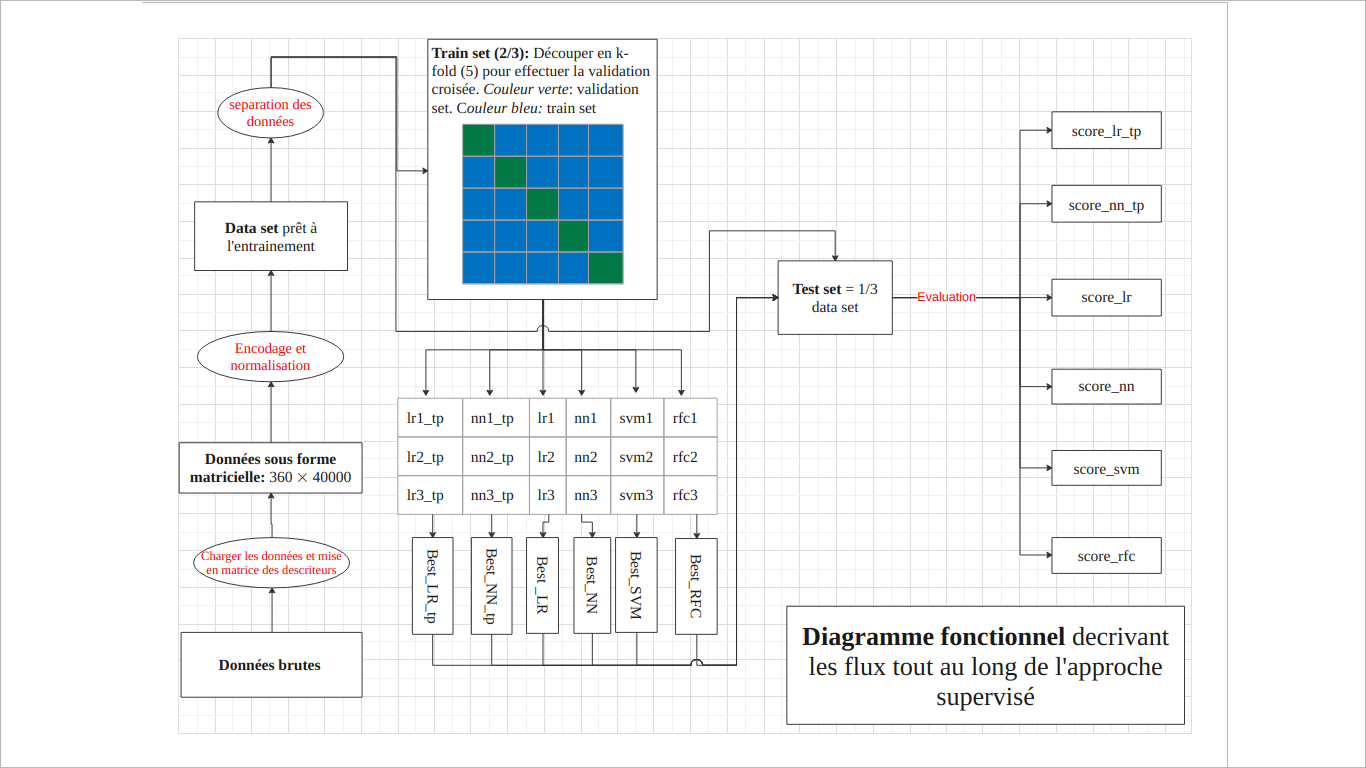

# **Partie 2: Approche supervisée sur descripteurs issus du scattering operator**

## **Chargement des descripteurs**

**<ins>Question</ins>: Chargez les données du fichier matlab imdb_200x200_SmallSonarTex_db_6classes_scatValOnly.mat**

In [ ]:
data = scipy.io.loadmat(r'/content/gdrive/My Drive/projet_IA/dataset/imdb_200x200_SmallSonarTex_db_6classes_scatValOnly.mat')
X=data['featVal']
X.shape

(360, 217)

## **Prétraitements**

**Question: Y-a-t-il besoin de normaliser les descripteurs? Si oui, que faut-il conserver comme information et pourquoi?**

*votre réponse ici:* Oui il faut normaliser les descripteurs. Car les les valeurs de la matrice ne sont du meme orde de grandeur. Par exemple le minimum est 0.61501724 et le maximun est 2323.0317. Lorsqu'on decide de normaliser les données par la methode standard, on conserve les valeurs de la moyenne et de l'ecart-type des données d'entrainement

In [ ]:
def normalisation(X):
  scale=preprocessing.StandardScaler()
  scale.fit(X)
  return scale

## **Apprentissage**

<strong><ins>Question</ins>: Séparer en deux ensembles de données et réalisez l'apprentissage successifs des modèles:
* régression logistique, réseaux de neurones, svm et random forest en utilisant les fonctions du package scikit-learn
</strong>

<span style='color:red'> **Pas de code à développer ici, réutiliser celui de la partie 1**</span>

In [ ]:
# On a pas besoin de normaliser les features carles valeurs des pixels sont ici comprises entre 0 et 1
# 70% de données d'entrainement et 30% de données de test
xtrain, xtest, ytrain, ytest = train_test_split(X, label_indices, test_size=0.3)
scale=normalisation(xtrain)
xtrain_scaled=scale.transform(xtrain)
xtest_scaled=scale.transform(xtest)

### **Entrainement des modèles**

#### **Regression Logistique**

In [ ]:
# On utilise le parametre Lambda pour entrainer le modèle et faire des predictions sur les données de test
classifier_LogR=LogisticRegression(C=1)
_=train_predict_model(classifier_LogR, xtrain_scaled, ytrain, xtest_scaled, ytest)

In [ ]:
# Calcul des scores pour pour le train set et le cross-validation set
train_size, train_error, cross_error=learning_curve(classifier_LogR, xtrain_scaled, ytrain, n_jobs=-1)

error in the cross_validation test= [0.12635294 0.05537255 0.03960784 0.03176471 0.01184314]
error in the train set test= [0.         0.         0.00181818 0.00129032 0.00199005]


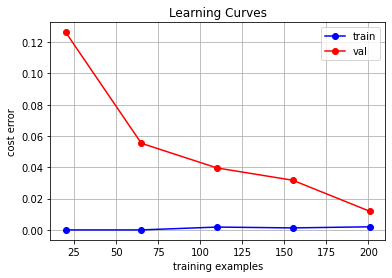

In [ ]:
# Affichage de la learning curve
train_error_mean = 1-np.mean(train_error, axis=1)
cross_error_mean = 1-np.mean(cross_error, axis=1)
print("error in the cross_validation test=", cross_error_mean)
print("error in the train set test=", train_error_mean)
plt.figure()
plt.grid()
plt.ylabel("cost error")
plt.xlabel("training examples")
plt.plot(train_size, train_error_mean, 'o-', color='blue')
plt.plot(train_size, cross_error_mean, 'o-', color='red')
plt.title("Learning Curves")
plt.legend(("train", "val"))
plt.show()

#### **Reseau de neurone**

In [ ]:
# Entrainement du bon modèle
classifier_nn = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, activation = 'relu', learning_rate_init=1e-5, solver='lbfgs',random_state=1, alpha=1.0)
_ = train_predict_model(classifier_nn, xtrain_scaled, ytrain, xtest_scaled, ytest)
print(classifier_nn.loss_)

0.053568419994926175


In [ ]:
# Calcul des scores pour le train set et le cross-validation set pour le reseaux de neurones
train_size, train_error, cross_error=learning_curve(classifier_nn, xtrain_scaled, ytrain, n_jobs=-1)

In [ ]:
# Affichage de la learning curve pour le reseau de neurone
train_error_mean = 1-np.mean(train_error, axis=1)
cross_error_mean = 1-np.mean(cross_error, axis=1)
print("error in the cross_validation test=", cross_error_mean)
print("error in the train set test=", train_error_mean)
plt.figure()
plt.grid()
plt.ylabel("cost error")
plt.xlabel("training examples")
plt.plot(train_size, train_error_mean, 'o-', color='blue', label="train cost error")
plt.plot(train_size, cross_error_mean, 'o-', color='red', label="cross_val cost error")
plt.title("Learning Curves")
plt.show()

#### **SVM**

In [ ]:
classifier_svm = svm.SVC(C=2.33, kernel="rbf", gamma=0.048)
_ = train_predict_model(classifier_svm, xtrain_scaled, ytrain, xtest_scaled, ytest)

In [ ]:
# calcul des scores pour la learning curve
train_size, train_error, cross_error=learning_curve(classifier_svm, xtrain_scaled, ytrain)

error in the cross_validation test= [0.31309804 0.1025098  0.06313725 0.04705882 0.03137255]
error in the train set test= [0.01       0.01538462 0.00727273 0.00516129 0.0039801 ]


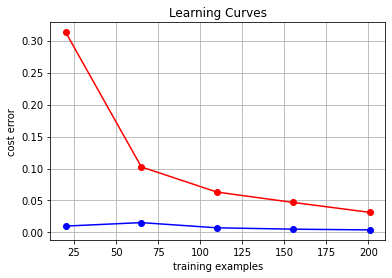

In [ ]:
# Affichage de la learning curve pour la SVM
train_error_mean = 1-np.mean(train_error, axis=1)
cross_error_mean = 1-np.mean(cross_error, axis=1)
print("error in the cross_validation test=", cross_error_mean)
print("error in the train set test=", train_error_mean)
plt.figure()
plt.grid()
plt.ylabel("cost error")
plt.xlabel("training examples")
plt.plot(train_size, train_error_mean, '-o', color='blue', label="train cost error")
plt.plot(train_size, cross_error_mean, '-o', color='red', label="cross_val cost error")
plt.title("Learning Curves")
plt.show()

#### **Random Forest**

In [ ]:
classifier_rfc = RandomForestClassifier(n_estimators=700, max_depth=10, max_leaf_nodes=35)
_=train_predict_model(classifier_rfc, xtrain_scaled, ytrain, xtest_scaled, ytest)

In [ ]:
# calcul des scores pour la learning curve
train_size, train_error, cross_error=learning_curve(classifier_rfc, xtrain_scaled, ytrain)

error in the cross_validation test= [0.36117647 0.13490196 0.07937255 0.06752941 0.05160784]
error in the train set test= [0. 0. 0. 0. 0.]


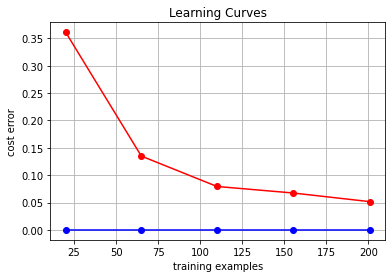

In [ ]:
# Affichage de la learning curve pour la SVM
train_error_mean = 1-np.mean(train_error, axis=1)
cross_error_mean = 1-np.mean(cross_error, axis=1)
print("error in the cross_validation test=", cross_error_mean)
print("error in the train set test=", train_error_mean)
plt.figure()
plt.grid()
plt.ylabel("cost error")
plt.xlabel("training examples")
plt.plot(train_size, train_error_mean, '-o', color='blue', label="train cost error")
plt.plot(train_size, cross_error_mean, '-o', color='red', label="cross_val cost error")
plt.title("Learning Curves")
plt.show()

## **Fixer les hyper paramètres**

**Question: Déterminez les hyper-paramètres (paramètre uniquement lié à l'algorithme d'apprentissage) de chaque algorithme. Comment allez vous les fixer?**

_votre réponse ici:_
* **Regression Logistique:** Lambda(coefficient de regularisation) et *le degrée du polynôme* (pour crée des frontieres de desicions plus complexe).
* **SVM:** *kernel*(entre 'lineaire', 'polynomial' et 'gaussien'), *Lambda* (parametre de regularisation) et eventuellement *gamma* (l'ecart-type du kernel gaussien) ou *d* (degrée du polynôme pour le kernel polynomial).
* **Random Forest:** Le nombre d'arbre, la profondeur de chaque arbre et le nombre maximal de feuille de chaque arbre.
* **reseaux de neurones:** Le paramètre de régularisation et la learning rate

Pour fixer les hyperparametres, on peut utiliser la fonction grid search de scikit-learn qui permet de trouver le meilleur paramètre dans une liste bien définie, ou on peut tracer les courbes d'erreur d'entrainement et de validation en fonction de l'hyperparametre comme dans la partie 1.

**<ins>Question</ins>:
Lisez le [tutoriel suivant](https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html\#sphx-glr-auto-examples-applications-plot-face-recognition-py) en faisant particulièrement attention à la façon dont est gérée la détermination des hyperparamètres et l'évaluation des performances. Reproduisez cette méthodologie en testant différents nombres de plis (fold).**

### Regression Logistique

In [ ]:
# Recherche du meilleur parametre "Lambda" pour la regression logistic 
List_params={}
List_clf1={}
for fold in [5,10, 15]:
  param_grid = {'C':  np.logspace(-3, 3, 7)} # Lambda=1/C, On recherche Lambda dans un intervalle de 10e-2 à 10e3
  clf_logistic_R1 = GridSearchCV(LogisticRegression(), param_grid, cv=fold)
  clf_logistic_R1.fit(xtrain_scaled, ytrain)
  List_params["fold_"+str(fold)]=clf_logistic_R1.best_params_['C']
  List_clf1["fold_"+str(fold)]=clf_logistic_R1.best_estimator_
print(List_params)

{'fold_5': 100.0, 'fold_10': 10.0, 'fold_15': 100.0}


In [ ]:
# Recherche du meilleur parametre "Lambda" pour la regression logistic polynomiale de degree 2
List_params={}
List_clf2={}
for fold in [5,10, 15]:
  model=make_pipeline(preprocessing.PolynomialFeatures(2), preprocessing.StandardScaler(), LogisticRegression())
  param_grid = {'logisticregression__C':  np.logspace(-3, 3, 7)} # Lambda=1/C, On recherche Lambda dans un intervalle de 10e-2 à 10e3
  clf_logistic_R2 = GridSearchCV(model, param_grid, cv=fold)
  clf_logistic_R2.fit(xtrain_scaled, ytrain)
  List_params["fold_"+str(fold)]=clf_logistic_R2.best_params_['logisticregression__C']
  List_clf2["fold_"+str(fold)]=clf_logistic_R2.best_estimator_
print(List_params)

{'fold_5': 1.0, 'fold_10': 10.0, 'fold_15': 1.0}


### Reseau de neurone

In [ ]:
# Recherche du meilleur Lambda avec Grid search
List_params={}
List_clf_nn={}
for fold in [5, 10, 15]:
  param_grid = {'alpha':  np.logspace(-5, 1, 7), 'learning_rate_init': [1e-1, 1e-3, 1e-5, 1e-7]}
  model=MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, solver='lbfgs', activation='relu', random_state=1)
  clf_nn = GridSearchCV(model, param_grid, cv=fold)
  clf_nn.fit(xtrain_scaled, ytrain)
  List_params["fold_"+str(fold)]=[clf_nn.best_params_['alpha'], clf_nn.best_params_['learning_rate_init']]
  List_clf_nn["fold_"+str(fold)]=clf_nn.best_estimator_
print(List_params)

{'fold_5': [0.01, 0.1], 'fold_10': [0.1, 0.1], 'fold_15': [0.1, 0.1]}


### SVM

In [ ]:
# Recherche du meilleur kernel et du parametre Lambda avec GridSearch
from sklearn import svm
List_params={}
List_clf_svm={}
for fold in [5, 10, 15]:
  param_grid = {'C':  np.logspace(-3, 5, 9), 'kernel': ["rbf", "linear", "poly"]}
  clf_svm = GridSearchCV(svm.SVC(), param_grid, cv=5)
  clf_svm.fit(xtrain_scaled, ytrain)
  List_params["fold_"+str(fold)]=[clf_svm.best_params_['C'], clf_svm.best_params_['kernel']]
  List_clf_svm["fold_"+str(fold)]=clf_svm.best_estimator_
print(List_params)

{'fold_5': [1.0, 'linear'], 'fold_10': [1.0, 'linear'], 'fold_15': [1.0, 'linear']}


### Random Forest

In [ ]:
n_leafs = [2, 5, 10, 15, 20, 25, 30, 35, 40]
List_params={}
List_clf_rfc={}
for fold in [5, 10, 15]:
  param_grid = {'max_depth':  np.linspace(2, 50, 10), 'max_leaf_nodes': n_leafs, 'n_estimators': [100, 200, 500, 700]}
  clf_rfc = GridSearchCV(RandomForestClassifier(n_estimators=100), param_grid, cv=fold)
  clf_rfc.fit(xtrain_scaled, ytrain)
  List_params["fold_"+str(fold)]=[clf_rfc.best_params_['n_estimators'], clf_rfc.best_params_['max_depth'], clf_rfc.best_params_['max_leaf_nodes']]
  List_clf_rfc["fold_"+str(fold)]=clf_rfc.best_estimator_
print(List_params)

{'fold_5': [100, 23.333333333333332, 35], 'fold_10': [200, 34.0, 25], 'fold_15': [100, 39.33333333333333, 30]}


### **Question: Évaluer les résultats et donner la valeur des paramètres optimau**x

#### Regression Logistique

In [ ]:
def find_key(v, dicts): 
    for k, val in dicts.items(): 
        if v == val: 
            return k 
    return "Clé n'existe pas"

In [ ]:

# Calcul des scores pour les trois regressions logistic
score_LR1={}
score_LR2={}
for key in List_clf1.keys():
  score_val1= cross_val_score(List_clf1[key], xtrain_scaled, ytrain).mean()
  score_val2= cross_val_score(List_clf2[key], xtrain_scaled, ytrain).mean()
  score_LR1[key]=score_val1
  score_LR2[key]=score_val2
print("score des regressions Logistiques Linéaire:", score_LR1)
print("score des regressions Logistiques poly d=2:", score_LR2)

print("========================================================================")
best_clf1=find_key(max(list(score_LR1.values())), score_LR1)
best_clf2=find_key(max(list(score_LR2.values())), score_LR2)
print("meilleur regresseur lineaire a pour kfold=", best_clf1)
print("meilleur regresseur poly d=2 a pour kfold=", best_clf2)

score des regressions Logistiques Linéaire: {'fold_5': 0.996078431372549, 'fold_10': 0.9920784313725491, 'fold_15': 0.996078431372549}
score des regressions Logistiques poly d=2: {'fold_5': 0.9841568627450981, 'fold_10': 0.980156862745098, 'fold_15': 0.9841568627450981}
meilleur regresseur lineaire a pour kfold= fold_5
meilleur regresseur poly d=2 a pour kfold= fold_5


In [ ]:
# Choix du meilleur regresseur 
clf_logistic_R=None
if np.argmax(np.array([score_LR1[best_clf1], score_LR2[best_clf2]]))==0:
  print("le meilleur model est lineaire")
  clf_logistic_R=List_clf1[best_clf1]
else:
  print("le meilleur model est polynomiale de degree 2")
  clf_logistic_R=List_clf2[best_clf2]

le meilleur model est lineaire


#### Reseau de neurone

In [ ]:
score_nn={}
for key in List_clf_nn.keys():
  score_val= cross_val_score(List_clf_nn[key], xtrain_scaled, ytrain).mean()
  score_nn[key]=score_val
print("score des reseaux de neurones:", score_nn)
print("========================================================================")
best_nn=find_key(max(list(score_nn.values())), score_nn)
print("meilleur reseau de neurone a pour kfold=", best_nn)
clf_nn=List_clf_nn[best_nn]

score des reseaux de neurones: {'fold_5': 0.9920784313725491, 'fold_10': 0.9920784313725491, 'fold_15': 0.9920784313725491}
meilleur reseau de neurone a pour kfold= fold_5


#### SVM

In [ ]:
score_svm={}
for key in List_clf_svm.keys():
  score_val= cross_val_score(List_clf_svm[key], xtrain_scaled, ytrain).mean()
  score_svm[key]=score_val
print("score des reseaux de neurones:", score_svm)
print("========================================================================")
best_svm=find_key(max(list(score_svm.values())), score_svm)
print("meilleur reseau de neurone a pour kfold=", best_svm)
clf_svm=List_clf_svm[best_svm]

score des reseaux de neurones: {'fold_5': 0.996078431372549, 'fold_10': 0.996078431372549, 'fold_15': 0.996078431372549}
meilleur reseau de neurone a pour kfold= fold_5


#### Random Forest

In [ ]:
score_rfc={}
for key in List_clf_rfc.keys():
  score_val= cross_val_score(List_clf_rfc[key], xtrain_scaled, ytrain).mean()
  score_rfc[key]=score_val
print("score des reseaux de neurones:", score_rfc)
print("========================================================================")
best_rfc=find_key(max(list(score_rfc.values())), score_rfc)
print("meilleur reseau de neurone a pour kfold=", best_rfc)
clf_rfc=List_clf_rfc[best_rfc]

score des reseaux de neurones: {'fold_5': 0.964313725490196, 'fold_10': 0.9603137254901961, 'fold_15': 0.9523137254901961}
meilleur reseau de neurone a pour kfold= fold_5


## **Apprendre le modèle final pour chaque classifieur**



### Regression Logistique

In [ ]:
#model.fit(xtrain_scaled, ytrain)
classifier_LR=clf_logistic_R
predictions_LR=classifier_LR.predict(xtest_scaled)

In [ ]:
# Calcul des scores pour pour le train set et le cross-validation set
train_size, train_error, cross_error=learning_curve(classifier_LR, xtrain_scaled, ytrain, n_jobs=-1)

error in the cross_validation test= [0.1105098  0.05145098 0.03176471 0.02784314 0.00792157]
error in the train set test= [0. 0. 0. 0. 0.]


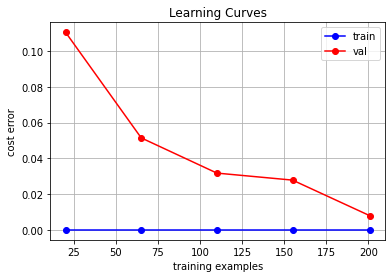

In [ ]:
# Affichage de la learning curve
train_error_mean = 1-np.mean(train_error, axis=1)
cross_error_mean = 1-np.mean(cross_error, axis=1)
print("error in the cross_validation test=", cross_error_mean)
print("error in the train set test=", train_error_mean)
plt.figure()
plt.grid()
plt.ylabel("cost error")
plt.xlabel("training examples")
plt.plot(train_size, train_error_mean, 'o-', color='blue')
plt.plot(train_size, cross_error_mean, 'o-', color='red')
plt.title("Learning Curves")
plt.legend(("train", "val"))
plt.show()

### Reseau de neurone

In [ ]:
classifier_nn=clf_nn
predictions_nn=classifier_nn.predict(xtest_scaled)

In [ ]:
# Calcul des scores pour le train set et le cross-validation set pour le reseaux de neurones
train_size, train_error, cross_error=learning_curve(classifier_nn, xtrain_scaled, ytrain, n_jobs=-1)

error in the cross_validation test= [0.10658824 0.04760784 0.02376471 0.02384314 0.00792157]
error in the train set test= [0. 0. 0. 0. 0.]


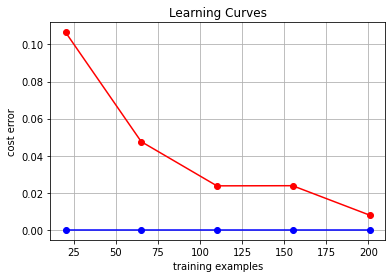

In [ ]:
# Affichage de la learning curve pour le reseau de neurone
train_error_mean = 1-np.mean(train_error, axis=1)
cross_error_mean = 1-np.mean(cross_error, axis=1)
print("error in the cross_validation test=", cross_error_mean)
print("error in the train set test=", train_error_mean)
plt.figure()
plt.grid()
plt.ylabel("cost error")
plt.xlabel("training examples")
plt.plot(train_size, train_error_mean, 'o-', color='blue', label="train cost error")
plt.plot(train_size, cross_error_mean, 'o-', color='red', label="cross_val cost error")
plt.title("Learning Curves")
plt.show()

### SVM

In [ ]:
classifier_svm=clf_svm
#classifier_svm.fit(xtrain_scaled, ytrain)
predictions_svm=classifier_svm.predict(xtest_scaled)

In [ ]:
# calcul des scores pour la learning curve
train_size, train_error, cross_error=learning_curve(classifier_svm, xtrain_scaled, ytrain)

error in the cross_validation test= [0.17011765 0.08713725 0.04352941 0.02784314 0.00392157]
error in the train set test= [0. 0. 0. 0. 0.]


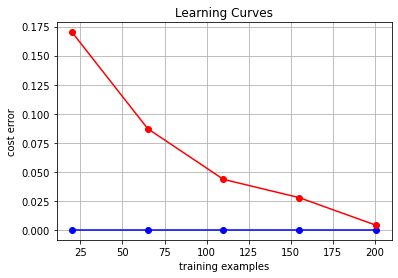

In [ ]:
# Affichage de la learning curve pour le reseau de neurone
train_error_mean = 1-np.mean(train_error, axis=1)
cross_error_mean = 1-np.mean(cross_error, axis=1)
print("error in the cross_validation test=", cross_error_mean)
print("error in the train set test=", train_error_mean)
plt.figure()
plt.grid()
plt.ylabel("cost error")
plt.xlabel("training examples")
plt.plot(train_size, train_error_mean, 'o-', color='blue', label="train cost error")
plt.plot(train_size, cross_error_mean, 'o-', color='red', label="cross_val cost error")
plt.title("Learning Curves")
plt.show()

### Random Forest

In [ ]:
classifier_rfc=clf_rfc
predictions_rfc=classifier_rfc.predict(xtest_scaled)

In [ ]:
# calcul des scores pour la learning curve
train_size, train_error, cross_error=learning_curve(classifier_rfc, xtrain_scaled, ytrain)

error in the cross_validation test= [0.21027451 0.10729412 0.09160784 0.06360784 0.03968627]
error in the train set test= [0. 0. 0. 0. 0.]


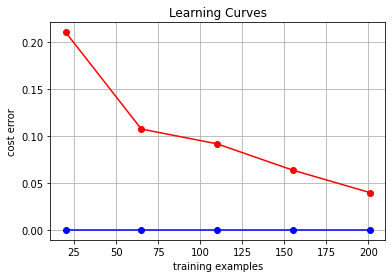

In [ ]:
# Affichage de la learning curve pour la SVM
train_error_mean = 1-np.mean(train_error, axis=1)
cross_error_mean = 1-np.mean(cross_error, axis=1)
print("error in the cross_validation test=", cross_error_mean)
print("error in the train set test=", train_error_mean)
plt.figure()
plt.grid()
plt.ylabel("cost error")
plt.xlabel("training examples")
plt.plot(train_size, train_error_mean, '-o', color='blue', label="train cost error")
plt.plot(train_size, cross_error_mean, '-o', color='red', label="cross_val cost error")
plt.title("Learning Curves")
plt.show()

## **Evaluer chaque classifieur**

### Regression Logistique

In [ ]:
display_model_performance_metrics(ytest, predictions_LR, np.array([0,1,2,3,4,5]))

Model Performance metrics:
------------------------------
Accuracy: 0.9907
Precision: 0.9913
Recall: 0.9907
F1 Score: 0.9907

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      1.00      1.00        16
           2       1.00      1.00      1.00        18
           3       1.00      0.94      0.97        17
           4       1.00      1.00      1.00        23
           5       0.94      1.00      0.97        17

    accuracy                           0.99       108
   macro avg       0.99      0.99      0.99       108
weighted avg       0.99      0.99      0.99       108


Prediction Confusion Matrix:
------------------------------
          Predicted:                    
                   0   1   2   3   4   5
Actual: 0         17   0   0   0   0   0
        1          0  16   0   0   0   0
        2          0   0  18   0   0   0
     

Dans la partie 2 de ce projet, il y'a eu une étape d'extraction des features. Cela à permit d'avoir 217 features au lieu de 40000. Du coup on obtient des meilleurs résultats.
Puisqu'on a un nombre de descripteurs réduit, on peut considerer comme hyperparamètre à chercher le degré du polynôme (entre 1 et 2) et le paramètre de régularisation. Après avoir trouver ces paramètre avec GridSearchCV, nous avons entrainer le modèle, tracer la learning curve puis évaluer le modèle.
D'abord on remarque sur la learning curve, le variance a fortement diminué. Cela peut s'expliquer par le fait qu'on a extraire les features pertinents et donc reduire au maximum le bruit. Aussi le bias est très faible (proche de zéro).

On obtient un résultat de 99% pour la précision et l'accuracy. Dont les classes 0,1,2,4 sont classés sans erreurs. Le modèle fait juste une erreure en classant une image comme appartenant à la classe 5 au lieu de la classe 4.

### Reseau de neurone

In [ ]:
display_model_performance_metrics(ytest, predictions_nn, np.array([0,1,2,3,4,5]))

Model Performance metrics:
------------------------------
Accuracy: 0.9815
Precision: 0.9825
Recall: 0.9815
F1 Score: 0.9815

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       1.00      0.94      0.97        16
           2       1.00      1.00      1.00        18
           3       1.00      0.94      0.97        17
           4       1.00      1.00      1.00        23
           5       0.94      1.00      0.97        17

    accuracy                           0.98       108
   macro avg       0.98      0.98      0.98       108
weighted avg       0.98      0.98      0.98       108


Prediction Confusion Matrix:
------------------------------
          Predicted:                    
                   0   1   2   3   4   5
Actual: 0         17   0   0   0   0   0
        1          1  15   0   0   0   0
        2          0   0  18   0   0   0
     

Avec les réseaux de neurones, nous avons obtenu un résultat de 98% comme précision et accuracy. Cela est largement supérieur à celui trouver dans la partie 1. Pour les mêmes raisons que précédemment, cela s'explique par l'étape d'extraction des données. Comme hyparamètre à trouver, on a la learning rate et le paramètre de régulariser. Après avoir chercher ces paramètres avec GridSearchCV, nous avons entrainé le modèle, tracer la learning curve puis évaluer.

La learning indique que la variance du modèle a grandement diminué. 

### SVM


In [ ]:
display_model_performance_metrics(ytest, predictions_svm, np.array([0,1,2,3,4,5]))

Model Performance metrics:
------------------------------
Accuracy: 0.9815
Precision: 0.982
Recall: 0.9815
F1 Score: 0.9815

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      0.94      0.97        16
           2       1.00      1.00      1.00        18
           3       0.94      0.94      0.94        17
           4       1.00      1.00      1.00        23
           5       0.94      1.00      0.97        17

    accuracy                           0.98       108
   macro avg       0.98      0.98      0.98       108
weighted avg       0.98      0.98      0.98       108


Prediction Confusion Matrix:
------------------------------
          Predicted:                    
                   0   1   2   3   4   5
Actual: 0         17   0   0   0   0   0
        1          0  15   0   1   0   0
        2          0   0  18   0   0   0
      

Dans cette partie, un résultat similaire que précédemment. Les hyperparamètres à trouver étaient le parametre de régularisation, le kernel et éventuellement le parametre gamma ou d(degré du polynôme).
Ces parametres ont été trouver avec GridSearchCV. La learning curve est similaire à la learning curve des modèles précédents.

On obtient 98% de précisions et d'accuracy

### Random Forest

In [ ]:
display_model_performance_metrics(ytest, predictions_rfc, np.array([0,1,2,3,4,5]))

Model Performance metrics:
------------------------------
Accuracy: 0.9444
Precision: 0.9476
Recall: 0.9444
F1 Score: 0.945

Model Classification report:
------------------------------
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        20
           1       1.00      0.95      0.97        19
           2       0.84      0.89      0.86        18
           3       0.94      1.00      0.97        16
           4       1.00      1.00      1.00        20
           5       0.88      0.93      0.90        15

    accuracy                           0.94       108
   macro avg       0.94      0.94      0.94       108
weighted avg       0.95      0.94      0.95       108


Prediction Confusion Matrix:
------------------------------
          Predicted:                    
                   0   1   2   3   4   5
Actual: 0         18   0   2   0   0   0
        1          0  18   0   1   0   0
        2          0   0  16   0   0   2
      

Dans cette partie, le même raisonnement s'applique. Les hyperparamètres à trouver étaient le nombre d'arbre dans la forêt, la profondeur de chaque arbre et le nombre de feuilles. Ces paramètres ont été trouver avec GridSearchCV. La learning curve est similaire à la learning curve des modèles précédents.

On obtient 94% de précisions et d'accuracy


# **Partie 4 Analyse finale des résultats**

**<ins>Question</ins>: Réalisez un diagramme fonctionnel décrivant le flux des données tout au long de l'approche supervisée. Ce diagramme devra faire apparaître au minimum: les trois ensembles d'images, les descripteurs, les différents algorithmes d'apprentissage, l'évaluation, les différents blocs de traitements.**

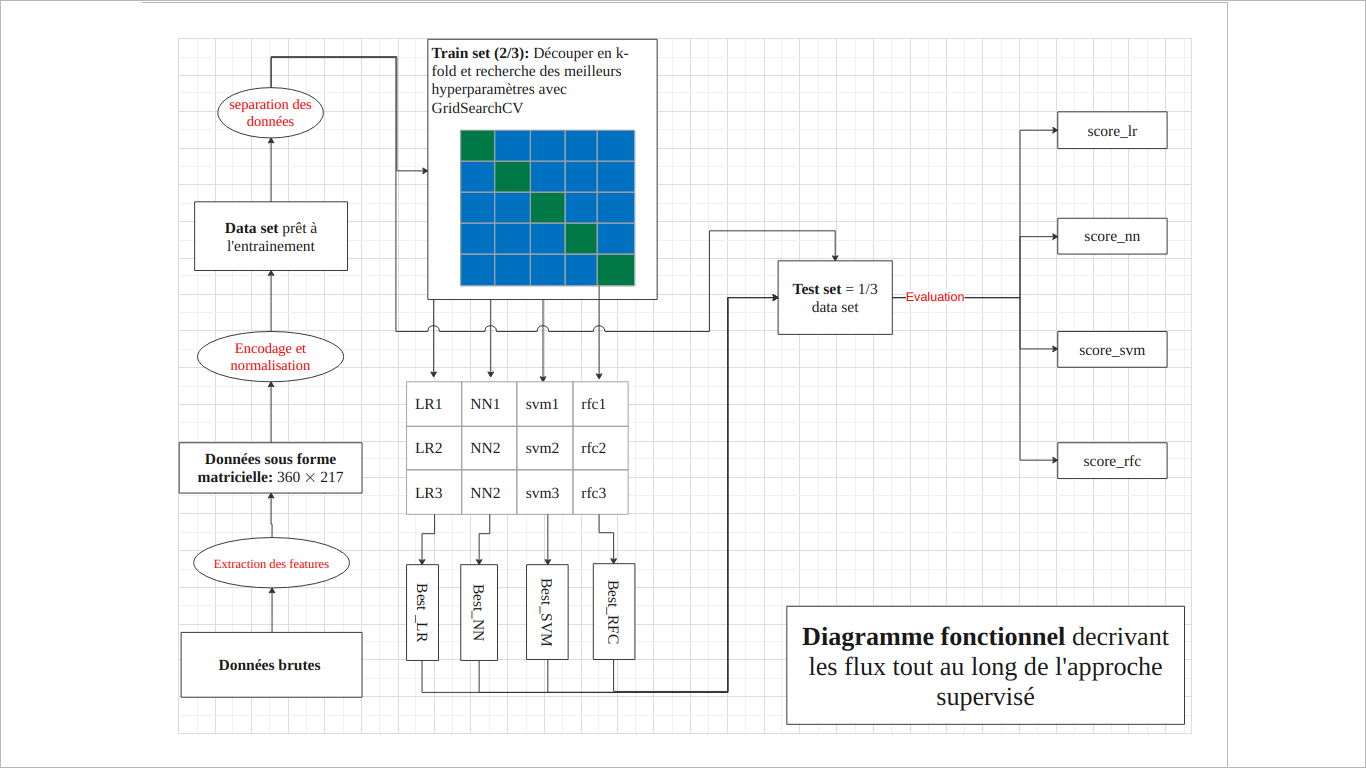

**<ins>Question</ins>: Faites une synthèse des résultats obtenus. Dresser en particulier des conclusions en fonction des descripteurs utilisés, des algorithmes utilisés et des prétraitements effectués.**

Dans ce projet, on s'est apercu de l'importance de l'étape d'extraction des features dans le processus d'apprentissage du machine learning. En effet pendant la première partie du projet, on avait realisé l'entrainement des modèles avec les données brutes des images. Les résultats obtenus étaient très mauvais. Cela peut s'expliquer par le fait que la dimension de l'espace des descripteurs est très grande. Et donc tous les features utilisés pour entrainer les modèles n'étaient pas pertinents. Donc il fallait chercher un moyen d'extraire les descripteurs pertinents (l'algorithme scattering operartor a été utilisé pour effectuer cette tâche). Comme pretraitement pendant le projet, nous avons l'étape de normalisation des données (qui permet d'accélérer la descente de gradiant), l'encodage des labels, la mise sous forme matriciel des données, la séparation des données en données d'entrainement et de test.

Les modèles appris étaient la regression logistique, les réseaux de neurones, la svm et le random forest. Le premier modèle appris était la regression logistique. Celui-ci considère une frontière de décision linéaire; Donc si les données ne sont pas linéairement séparables, on obtiendra pas de meilleurs résultats. Le deuxième modèle implémenté est le reseau de neurone. Celui-ci peut modéliser des frontières de décision non linéaire (par empilement des couches de neurones).Mais plus on emplie les couches, plus le modèle devient sujet au surapprentissage. Le troisième modèle appris est la svm. Qui grâce à son kernel nous donne l'avantage de créer des frontières de décision non-linéaire. Enfin le dernier modèle appris est le random forest, qui considère une forèt d'arbre de décision.